Predicting whether income exceeds $50K/yr based on census data. 

dataset - https://archive.ics.uci.edu/dataset/2/adult

Attributes 

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
income: >50K, <=50K.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [110]:
import os

## Create DataFrames

In [111]:
# define training and testing file paths
train_data_file_path = 'Dataset\\adult.data'
test_data_file_path = 'Dataset\\adult.test'

In [112]:
# define column names
column_names = [
    "Age", 
    "Work_class", 
    "Final_Weight", 
    "Education", 
    "Education_Num", 
    "Marital_Status", 
    "Occupation",
    "Relationship", 
    "Race", 
    "Sex", 
    "Capital_Gain", 
    "Capital_Loss", 
    "Hours_per_Week", 
    "Native_Country",
    "Income"
]

Reference - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [113]:
# read training dataset into DataFrame
try:
    train_data = pd.read_csv(train_data_file_path, delimiter=',', names=column_names, skipinitialspace=True)
except FileNotFoundError:
    print(f"Error: File '{train_data_file_path}' not found.")
    exit()

In [114]:
# preview after adding into DataFrame
train_data.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [115]:
# read testing dataset into DataFrame
# 1st row (header)should remove in adult.test file 
try:
    test_data = pd.read_csv(test_data_file_path, delimiter=',', names=column_names, skipinitialspace=True, skiprows=1)
except FileNotFoundError:
    print(f"Error: File '{test_data_file_path}' not found.")
    exit()

In [116]:
# preview after adding into DataFrame
test_data.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K.
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K.
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K.
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K.


### Merge DataFrames 

Reference -  https://pandas.pydata.org/docs/reference/api/pandas.concat.html
             https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html#

In [117]:
# check data types of Training and Testing DataFrames
print("Training Data")
print(train_data.dtypes)
print("")
print("Testing Data")
print(test_data.dtypes)

Training Data
Age                int64
Work_class        object
Final_Weight       int64
Education         object
Education_Num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_Week     int64
Native_Country    object
Income            object
dtype: object

Testing Data
Age                int64
Work_class        object
Final_Weight       int64
Education         object
Education_Num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_Week     int64
Native_Country    object
Income            object
dtype: object


In [118]:
# check null values of both DataFrames
print("Training Data")
print(train_data.isnull().sum())
print("")
print("Testing Data")
print(test_data.isnull().sum())

Training Data
Age               0
Work_class        0
Final_Weight      0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_Week    0
Native_Country    0
Income            0
dtype: int64

Testing Data
Age               0
Work_class        0
Final_Weight      0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_Week    0
Native_Country    0
Income            0
dtype: int64


In [119]:
# there are no any null values in both DataFrames
# There is no difference in data types of columns
# so we can combine into a single DataFrame
census_income_df = pd.concat([train_data, test_data])

In [120]:
census_income_df.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [121]:
# Shuffle the merged data for prevents any bias and ensure the data is randomized
census_income_df = census_income_df.sample(frac=1).reset_index(drop=True)

In [122]:
census_income_df.head(10)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,80,Private,227210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,40,United-States,>50K.
1,53,Self-emp-inc,200400,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,>50K.
2,29,Private,196564,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K.
3,66,?,190324,HS-grad,9,Married-civ-spouse,?,Husband,Black,Male,0,0,18,United-States,<=50K
4,33,Private,113364,HS-grad,9,Divorced,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
5,46,Private,134242,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K.
6,29,Private,200468,10th,6,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
7,27,Private,132963,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
8,46,Private,154430,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,50,United-States,>50K
9,34,Private,81206,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Black,Male,0,0,40,United-States,<=50K


In [123]:
# CSV file saving directory checking
directory = os.path.dirname(train_data_file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

In [124]:
# define file paths to save datasets as CSV
census_income_df_file_path = os.path.join(directory, 'census_income_datset.csv')

In [125]:
# save training and testing DataFrames as CSV
try:
    census_income_df.to_csv(census_income_df_file_path, index=False)
    print(f"Census Income Data CSV file saved successfully at: {census_income_df_file_path}")

except PermissionError:
    print(f"Error: Permission denied to save files in directory: {directory}")

Census Income Data CSV file saved successfully at: Dataset\census_income_datset.csv


## Data Cleaning

In [126]:
census_income_df.shape

(48842, 15)

### 1. Check null values

In [127]:
census_income_df.isnull().sum()

Age               0
Work_class        0
Final_Weight      0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_Week    0
Native_Country    0
Income            0
dtype: int64

In [128]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      48842 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  48842 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Currently there are no any null values

In [129]:
# check unique values
census_income_df.nunique()

Age                  74
Work_class            9
Final_Weight      28523
Education            16
Education_Num        16
Marital_Status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_Gain        123
Capital_Loss         99
Hours_per_Week       96
Native_Country       42
Income                4
dtype: int64

In [130]:
# unique values in each columns
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[80 53 29 66 33 46 27 34 25 18 47 21 31 32 44 19 28 35 55 90 56 52 23 20
 22 51 38 39 72 71 43 41 54 67 30 40 24 49 37 50 48 26 42 62 58 57 17 45
 36 74 65 60 59 68 69 81 61 79 63 76 75 83 70 64 73 78 77 84 82 87 89 85
 88 86]


Work_class
['Private' 'Self-emp-inc' '?' 'Local-gov' 'Self-emp-not-inc' 'State-gov'
 'Federal-gov' 'Never-worked' 'Without-pay']


Final_Weight
[227210 200400 196564 ... 238287 240150 162884]


Education
['Bachelors' 'Doctorate' 'HS-grad' 'Some-college' '10th' 'Masters' '9th'
 'Assoc-acdm' 'Assoc-voc' '11th' '12th' '1st-4th' 'Prof-school' '7th-8th'
 '5th-6th' 'Preschool']


Education_Num
[13 16  9 10  6 14  5 12 11  7  8  2 15  4  3  1]


Marital_Status
['Married-civ-spouse' 'Divorced' 'Never-married' 'Separated' 'Widowed'
 'Married-spouse-absent' 'Married-AF-spouse']


Occupation
['Exec-managerial' 'Adm-clerical' '?' 'Prof-specialty' 'Handlers-cleaners'
 'Craft-repair' 'Machine-op-inspct' 'Other-service' 'Sales'
 'Protective-serv' 'Tech-support' 'Transport

There are missing values represented by '?' in Work_class, Occupation and Native_Country columns.
Also have to convert '<=50K.' into '<=50K' and '>50K.' into '>50K' in Income column.

In [131]:
# replace '?' with NaN
#census_income_df.replace(' ?', pd.NA, inplace=True)

census_income_df.replace('?', np.nan, inplace=True) 

In [132]:
# replace values in 'Income' column
census_income_df['Income'] = census_income_df['Income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'})

In [133]:
# check unique values in each columns after modifications
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[80 53 29 66 33 46 27 34 25 18 47 21 31 32 44 19 28 35 55 90 56 52 23 20
 22 51 38 39 72 71 43 41 54 67 30 40 24 49 37 50 48 26 42 62 58 57 17 45
 36 74 65 60 59 68 69 81 61 79 63 76 75 83 70 64 73 78 77 84 82 87 89 85
 88 86]


Work_class
['Private' 'Self-emp-inc' nan 'Local-gov' 'Self-emp-not-inc' 'State-gov'
 'Federal-gov' 'Never-worked' 'Without-pay']


Final_Weight
[227210 200400 196564 ... 238287 240150 162884]


Education
['Bachelors' 'Doctorate' 'HS-grad' 'Some-college' '10th' 'Masters' '9th'
 'Assoc-acdm' 'Assoc-voc' '11th' '12th' '1st-4th' 'Prof-school' '7th-8th'
 '5th-6th' 'Preschool']


Education_Num
[13 16  9 10  6 14  5 12 11  7  8  2 15  4  3  1]


Marital_Status
['Married-civ-spouse' 'Divorced' 'Never-married' 'Separated' 'Widowed'
 'Married-spouse-absent' 'Married-AF-spouse']


Occupation
['Exec-managerial' 'Adm-clerical' nan 'Prof-specialty' 'Handlers-cleaners'
 'Craft-repair' 'Machine-op-inspct' 'Other-service' 'Sales'
 'Protective-serv' 'Tech-support' 'Transport

### 2. Handle null values

Reference - https://pandas.pydata.org/docs/user_guide/missing_data.html

In [134]:
#check how many records in the dataset 
census_income_df.shape

(48842, 15)

In [135]:
# number of NaN values in each row
nan_rows_count = census_income_df.isna().sum(axis=1)

# total number of rows with NaN values
total_nan_rows = (nan_rows_count > 0).sum()

print("Total number of rows with NaN values:", total_nan_rows)


Total number of rows with NaN values: 3620


There are so many rows have nan values. So can't drop that rows. Use imputation to handle null values

In [136]:
# Non-Null count
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      46043 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      46033 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  47985 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Non value amounts in the dataset.
Work_class - 2799 Null values,
Occupation - 2809 Null values,
Native_Country - 857 Null values

In [137]:
census_income_df.head() 

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,80,Private,227210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,40,United-States,>50K
1,53,Self-emp-inc,200400,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,>50K
2,29,Private,196564,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K
3,66,NaN,190324,HS-grad,9,Married-civ-spouse,NaN,Husband,Black,Male,0,0,18,United-States,<=50K
4,33,Private,113364,HS-grad,9,Divorced,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K


### Handle Work class column Null values

In [138]:
# classes of Income
print(census_income_df['Income'].unique())

['>50K' '<=50K']


Basically we should consider Income. So fill missing values in the 'Work_class' column based on the Mode for each income class (<=50K or >50K).

Split dataset based on Income. Can split into 2 classes.

In [139]:
income_less_50k = census_income_df[census_income_df['Income'] == '<=50K']
income_greater_50k = census_income_df[census_income_df['Income'] == '>50K']

In [140]:
income_less_50k.head()

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
2,29,Private,196564,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K
3,66,NaN,190324,HS-grad,9,Married-civ-spouse,NaN,Husband,Black,Male,0,0,18,United-States,<=50K
4,33,Private,113364,HS-grad,9,Divorced,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
5,46,Private,134242,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
6,29,Private,200468,10th,6,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [141]:
income_greater_50k.head()

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,80,Private,227210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,40,United-States,>50K
1,53,Self-emp-inc,200400,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,>50K
8,46,Private,154430,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,50,United-States,>50K
15,33,Private,98168,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,30,United-States,>50K
30,56,Private,282023,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K


In [142]:
# Filter the 'Work Class' column based on income

under50K_workClass = income_less_50k['Work_class'].value_counts()
over50K_workClass = income_greater_50k['Work_class'].value_counts()

In [143]:
under50K_workClass

Work_class
Private             26519
Self-emp-not-inc     2785
Local-gov            2209
State-gov            1451
Federal-gov           871
Self-emp-inc          757
Without-pay            19
Never-worked           10
Name: count, dtype: int64

In [144]:
over50K_workClass

Work_class
Private             7387
Self-emp-not-inc    1077
Self-emp-inc         938
Local-gov            927
Federal-gov          561
State-gov            530
Without-pay            2
Name: count, dtype: int64

Plot Work classes according to the Income classes

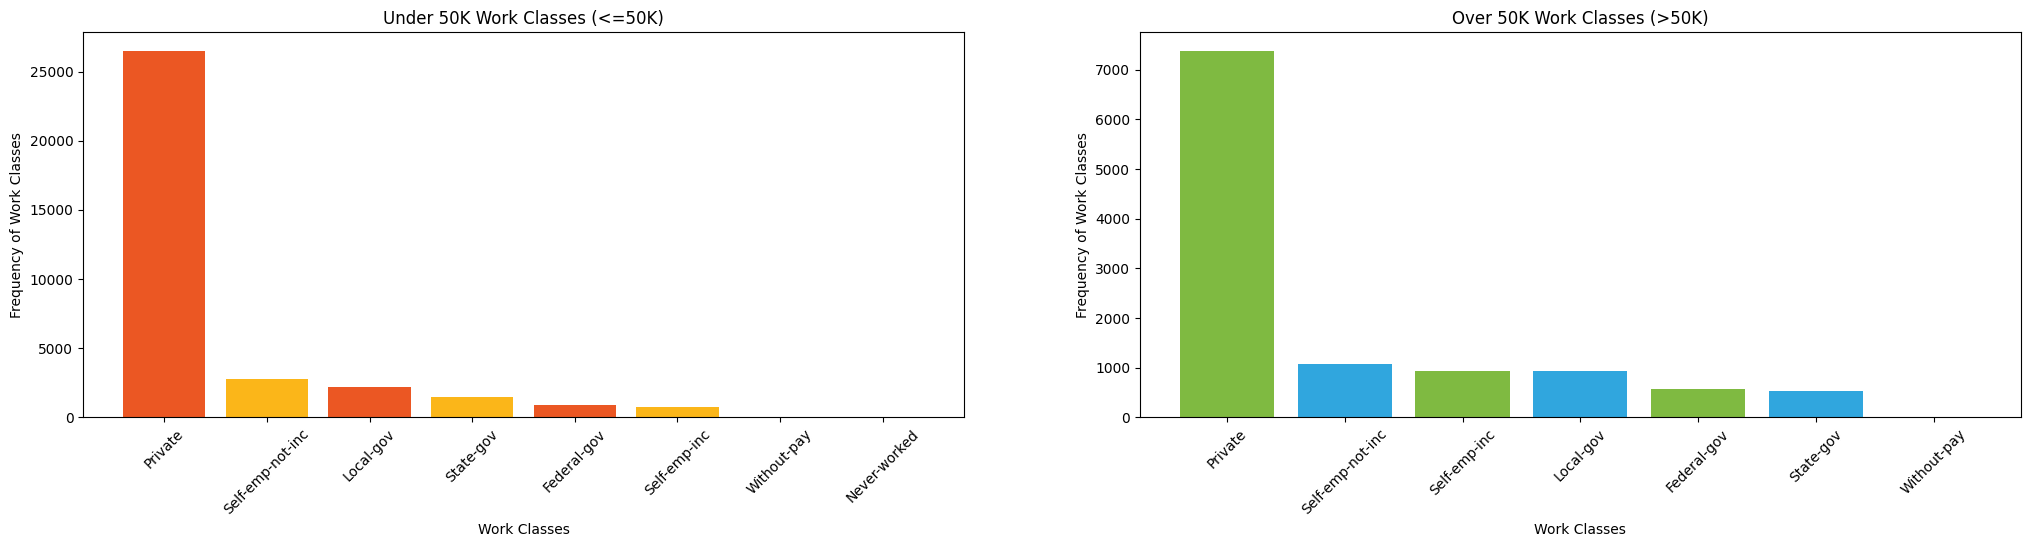

In [145]:
#colors
under50K_color = ['#EB5723', '#FBB619']
over50K_color = ['#7FBA41', '#30A6DE']

# Plotting them side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (25,5))

ax1.bar(under50K_workClass.index,under50K_workClass.values,color=under50K_color)
ax1.set_xlabel("Work Classes")
ax1.set_ylabel("Frequency of Work Classes")
ax1.set_title("Under 50K Work Classes (<=50K)")
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

ax2.bar(over50K_workClass.index,over50K_workClass.values,color=over50K_color)
ax2.set_xlabel("Work Classes")
ax2.set_ylabel("Frequency of Work Classes")
ax2.set_title("Over 50K Work Classes (>50K)")
ax2.tick_params(axis='x', rotation=45) 

In [146]:
# find Work class mode for each income class
mode_less_50k_workclass = income_less_50k['Work_class'].mode()[0]
mode_greater_50k_workclass = income_greater_50k['Work_class'].mode()[0]
print('Mode of Less than 50k income:', mode_less_50k_workclass )
print('Mode of Greater than 50k income:', mode_greater_50k_workclass)

Mode of Less than 50k income: Private
Mode of Greater than 50k income: Private


So the mode of Work classes for the both Income classes is 'Private'.Now we can fill null values of 'Work_class' column with 'Private'.

In [147]:
# Fill missing values based on income class
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Work_class'].isnull()), 'Work_class'] = mode_less_50k_workclass
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Work_class'].isnull()), 'Work_class'] = mode_greater_50k_workclass

Check if 'Work_class' column is ok now.

In [148]:
#check unique values of Work_class column
print(census_income_df['Work_class'].unique())

['Private' 'Self-emp-inc' 'Local-gov' 'Self-emp-not-inc' 'State-gov'
 'Federal-gov' 'Never-worked' 'Without-pay']


In [149]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      46033 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  47985 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


'Work class' column doesn't have any null values

### Handle Occupation column Null values

In [150]:
# Filter the 'Occupation' column based on income

under50K_occupation = income_less_50k['Occupation'].value_counts()
over50K_occupation = income_greater_50k['Occupation'].value_counts()

In [151]:
under50K_occupation

Occupation
Adm-clerical         4843
Craft-repair         4729
Other-service        4719
Sales                4029
Prof-specialty       3388
Exec-managerial      3178
Machine-op-inspct    2650
Handlers-cleaners    1934
Transport-moving     1874
Farming-fishing      1317
Tech-support         1026
Protective-serv       675
Priv-house-serv       239
Armed-Forces           10
Name: count, dtype: int64

In [152]:
over50K_occupation

Occupation
Exec-managerial      2908
Prof-specialty       2784
Sales                1475
Craft-repair         1383
Adm-clerical          768
Transport-moving      481
Tech-support          420
Machine-op-inspct     372
Protective-serv       308
Other-service         204
Farming-fishing       173
Handlers-cleaners     138
Armed-Forces            5
Priv-house-serv         3
Name: count, dtype: int64

Plot Occupations according to the Income classes

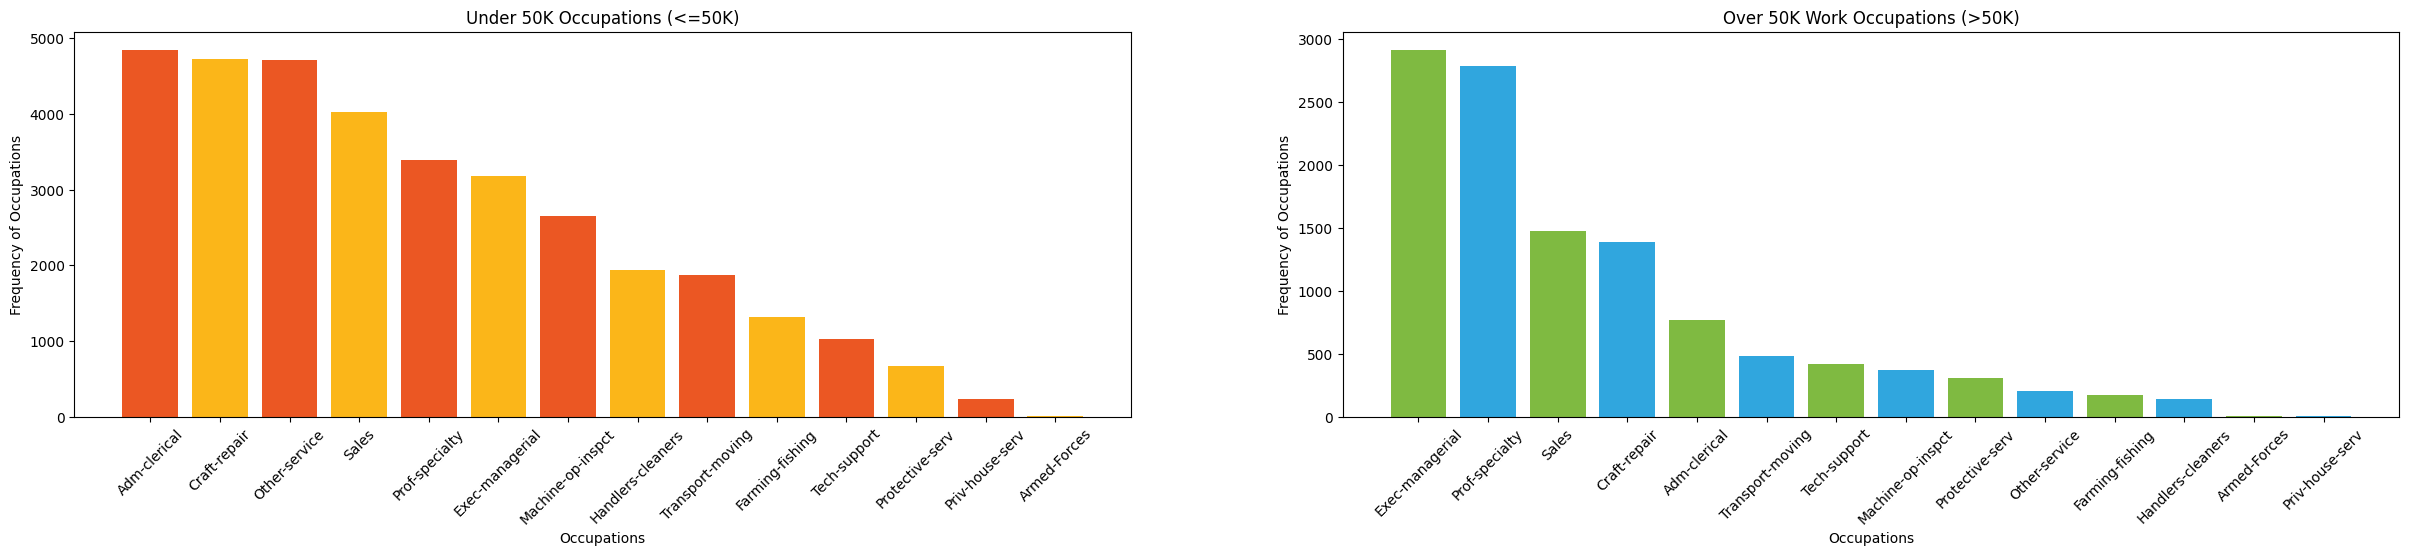

In [153]:
#colors
under50K_color = ['#EB5723', '#FBB619']
over50K_color = ['#7FBA41', '#30A6DE']

# Plotting them side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (30,5))

ax1.bar(under50K_occupation.index,under50K_occupation.values,color=under50K_color)
ax1.set_xlabel("Occupations")
ax1.set_ylabel("Frequency of Occupations")
ax1.set_title("Under 50K Occupations (<=50K)")
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability


ax2.bar(over50K_occupation.index,over50K_occupation.values,color=over50K_color)
ax2.set_xlabel("Occupations")
ax2.set_ylabel("Frequency of Occupations")
ax2.set_title("Over 50K Work Occupations (>50K)")
ax2.tick_params(axis='x', rotation=45)

In [154]:
# find Occupation mode for each income class
mode_less_50k_occupation = income_less_50k['Occupation'].mode()[0]
mode_greater_50k_occupation = income_greater_50k['Occupation'].mode()[0]
print('Mode of Less than 50k income:', mode_less_50k_occupation)
print('Mode of Greater than 50k income:', mode_greater_50k_occupation)

Mode of Less than 50k income: Adm-clerical
Mode of Greater than 50k income: Exec-managerial


So the mode of Occupations for '<=50K' Income classes is 'Adm-clerical'.And the mode of Occupations for '>50K' Income classes is 'Exec-managerial'.Now we can fill null values of 'Work_class' column.

In [155]:
# Fill missing values based on income class
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Occupation'].isnull()), 'Occupation'] = mode_less_50k_occupation
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Occupation'].isnull()), 'Occupation'] = mode_greater_50k_occupation

Check if 'Occupation' column is ok now.

In [156]:
#check unique values of Work_class column
print(census_income_df['Occupation'].unique())

['Exec-managerial' 'Adm-clerical' 'Prof-specialty' 'Handlers-cleaners'
 'Craft-repair' 'Machine-op-inspct' 'Other-service' 'Sales'
 'Protective-serv' 'Tech-support' 'Transport-moving' 'Farming-fishing'
 'Priv-house-serv' 'Armed-Forces']


In [157]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      48842 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  47985 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


'Occupation' column doesn't have any null values

### Handle Native Country column Null values

In [158]:
# Filter the 'Native country' column based on income

under50K_nativeCountry = income_less_50k['Native_Country'].value_counts()
over50K_nativeCountry = income_greater_50k['Native_Country'].value_counts()

In [159]:
under50K_nativeCountry

Native_Country
United-States                 33138
Mexico                          904
Philippines                     210
Puerto-Rico                     164
Germany                         148
El-Salvador                     144
Canada                          119
Cuba                            104
Dominican-Republic               98
South                            95
Jamaica                          91
India                            89
China                            86
Guatemala                        85
Columbia                         81
England                          80
Vietnam                          79
Italy                            71
Poland                           70
Haiti                            66
Japan                            60
Portugal                         55
Nicaragua                        46
Peru                             42
Ecuador                          39
Taiwan                           39
Iran                             37
Greece       

In [160]:
over50K_nativeCountry

Native_Country
United-States                 10694
Philippines                      85
Canada                           63
India                            62
Germany                          58
Mexico                           47
England                          47
China                            36
Cuba                             34
Italy                            34
Japan                            32
Taiwan                           26
Iran                             22
Puerto-Rico                      20
South                            20
Greece                           18
Poland                           17
France                           16
Jamaica                          15
Portugal                         12
El-Salvador                      11
Ireland                          11
Cambodia                          9
Haiti                             9
Yugoslavia                        8
Hong                              8
Vietnam                           7
Hungary      

Mostly includes United States data.Majority of both income groups are from US.

In [161]:
# Create a cross-tabulation
cross_tab = pd.crosstab(census_income_df['Native_Country'], census_income_df['Income'])

# Display the cross-tabulation
print(cross_tab)

Income                      <=50K   >50K
Native_Country                          
Cambodia                       19      9
Canada                        119     63
China                          86     36
Columbia                       81      4
Cuba                          104     34
Dominican-Republic             98      5
Ecuador                        39      6
El-Salvador                   144     11
England                        80     47
France                         22     16
Germany                       148     58
Greece                         31     18
Guatemala                      85      3
Haiti                          66      9
Holand-Netherlands              1      0
Honduras                       18      2
Hong                           22      8
Hungary                        13      6
India                          89     62
Iran                           37     22
Ireland                        26     11
Italy                          71     34
Jamaica         

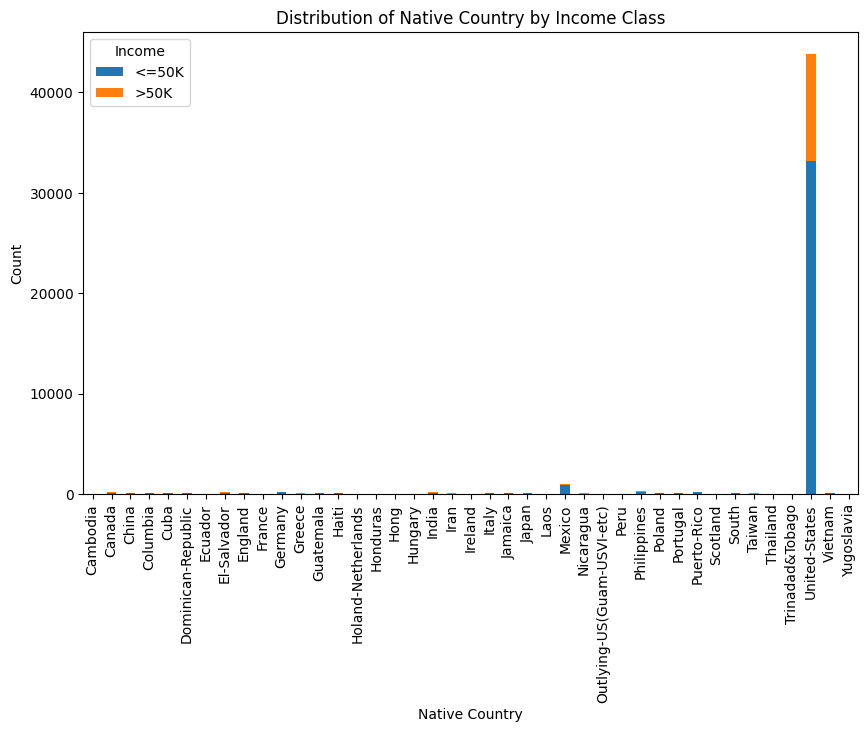

In [162]:
# Plot the cross-tabulation as a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Native Country by Income Class')
plt.xlabel('Native Country')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

Plot Native countries according to the Income classes

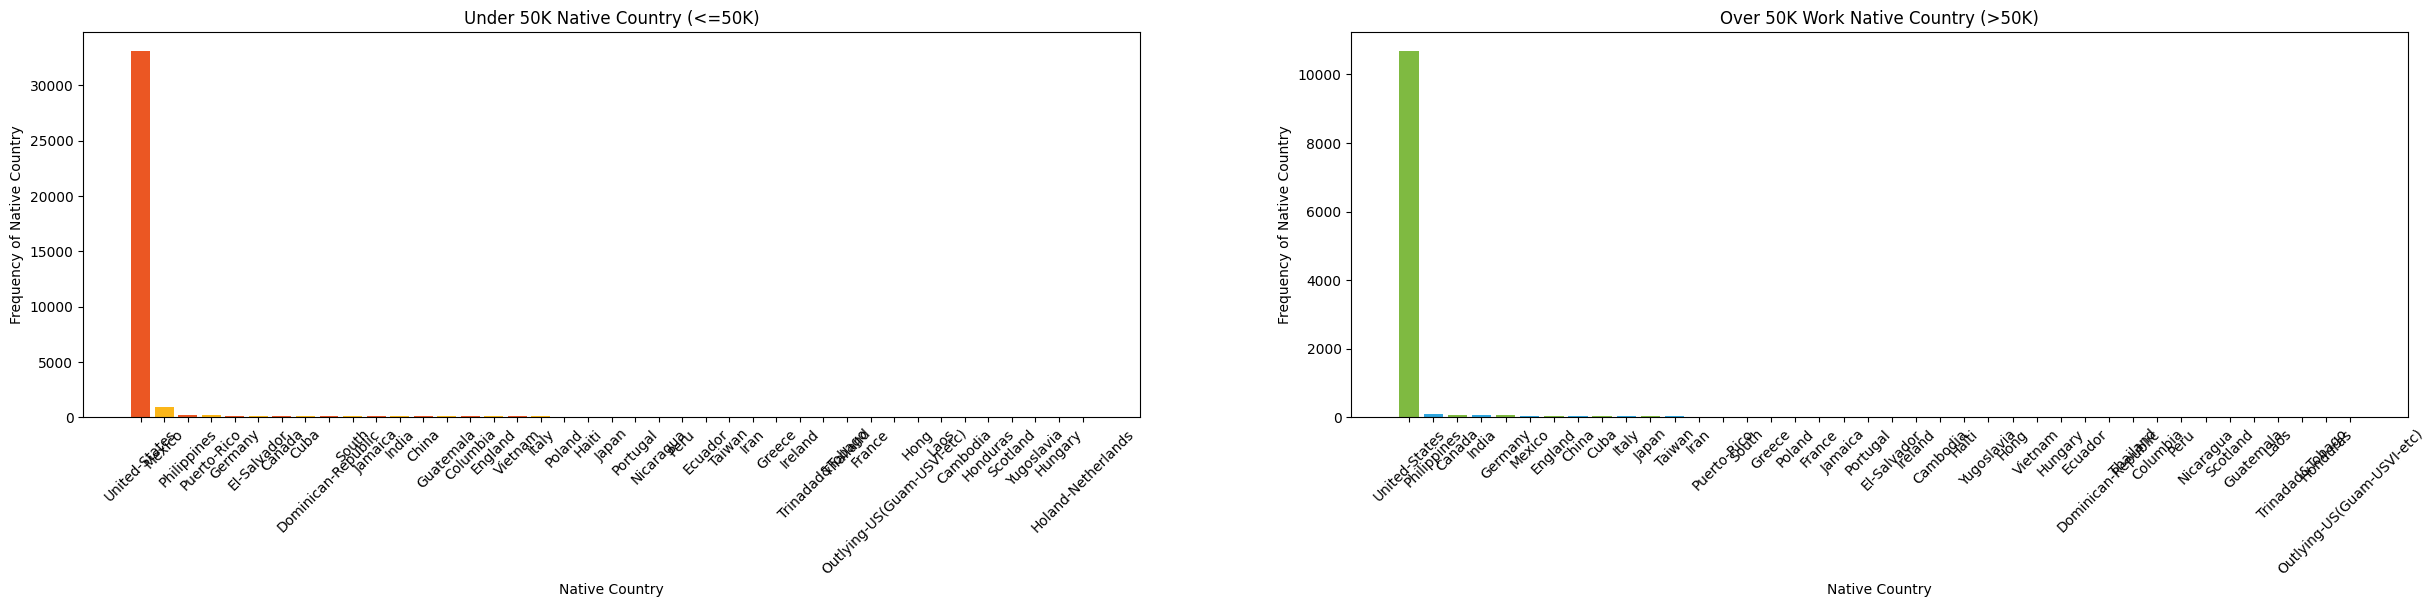

In [163]:
#colors 
under50K_color = ['#EB5723', '#FBB619']
over50K_color = ['#7FBA41', '#30A6DE']

# Plotting them side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (30,5))

ax1.bar(under50K_nativeCountry.index,under50K_nativeCountry.values,color=under50K_color)
ax1.set_xlabel("Native Country")
ax1.set_ylabel("Frequency of Native Country")
ax1.set_title("Under 50K Native Country (<=50K)")
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability


ax2.bar(over50K_nativeCountry.index,over50K_nativeCountry.values,color=over50K_color)
ax2.set_xlabel("Native Country")
ax2.set_ylabel("Frequency of Native Country")
ax2.set_title("Over 50K Work Native Country (>50K)")
ax2.tick_params(axis='x', rotation=45)

In [164]:
# Calculate the count of "United-States" occurrences
us_count = census_income_df['Native_Country'].value_counts().get('United-States', 0)

# Calculate the total number of entries in the "Native_Country" column
total_entries = len(census_income_df)

# Calculate the percentage
us_percentage = (us_count / total_entries) * 100

print("Percentage of 'United-States' in Native country column:", us_percentage)

Percentage of 'United-States' in Native country column: 89.74243478973015


So I can fill null values of Native Country column with "United-States"

In [165]:
census_income_df['Native_Country'] = census_income_df['Native_Country'].fillna('United-States')

Check if 'Native country' column is ok now.

In [166]:
#check unique values of Work_class column
print(census_income_df['Native_Country'].unique())

['United-States' 'Peru' 'Cuba' 'Greece' 'South' 'Mexico' 'Japan' 'Germany'
 'India' 'Dominican-Republic' 'El-Salvador' 'Guatemala' 'England' 'France'
 'Philippines' 'Poland' 'Ecuador' 'Portugal' 'Canada' 'Hungary' 'China'
 'Hong' 'Jamaica' 'Columbia' 'Taiwan' 'Vietnam' 'Nicaragua' 'Iran'
 'Puerto-Rico' 'Haiti' 'Italy' 'Trinadad&Tobago' 'Cambodia'
 'Outlying-US(Guam-USVI-etc)' 'Ireland' 'Laos' 'Yugoslavia' 'Honduras'
 'Scotland' 'Thailand' 'Holand-Netherlands']


In [167]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48842 non-null  int64 
 1   Work_class      48842 non-null  object
 2   Final_Weight    48842 non-null  int64 
 3   Education       48842 non-null  object
 4   Education_Num   48842 non-null  int64 
 5   Marital_Status  48842 non-null  object
 6   Occupation      48842 non-null  object
 7   Relationship    48842 non-null  object
 8   Race            48842 non-null  object
 9   Sex             48842 non-null  object
 10  Capital_Gain    48842 non-null  int64 
 11  Capital_Loss    48842 non-null  int64 
 12  Hours_per_Week  48842 non-null  int64 
 13  Native_Country  48842 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


All null values are filled

### 3. Remove duplicate rows

Reference - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

In [168]:
# Number of Rows and Cols in DF
census_income_df.shape

(48842, 15)

In [169]:
# Check how many duplicate rows in the DF
duplicate_rows = census_income_df.duplicated().sum()

print("Number of duplicate rows :", duplicate_rows)

Number of duplicate rows : 53


In [170]:
# keep - Drop duplicates except for the first occurrence.
# inplace - Modify the DataFrame directly
census_income_df.drop_duplicates(keep='first', inplace=True)

In [171]:
# Number of Rows and Cols after dropping the duplicate Rows in DF
census_income_df.shape

(48789, 15)

In [172]:
census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48789 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48789 non-null  int64 
 1   Work_class      48789 non-null  object
 2   Final_Weight    48789 non-null  int64 
 3   Education       48789 non-null  object
 4   Education_Num   48789 non-null  int64 
 5   Marital_Status  48789 non-null  object
 6   Occupation      48789 non-null  object
 7   Relationship    48789 non-null  object
 8   Race            48789 non-null  object
 9   Sex             48789 non-null  object
 10  Capital_Gain    48789 non-null  int64 
 11  Capital_Loss    48789 non-null  int64 
 12  Hours_per_Week  48789 non-null  int64 
 13  Native_Country  48789 non-null  object
 14  Income          48789 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


### 4.Standardizing Data

Data standardization transforms data into a consistent format across datasets, typically by scaling it to have a mean of zero and a standard deviation of one. This ensures uniformity and facilitates accurate comparison and analysis across variables.

Reference - https://atlan.com/standardize-data/ , 

In [173]:
# unique values in each columns
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[80 53 29 66 33 46 27 34 25 18 47 21 31 32 44 19 28 35 55 90 56 52 23 20
 22 51 38 39 72 71 43 41 54 67 30 40 24 49 37 50 48 26 42 62 58 57 17 45
 36 74 65 60 59 68 69 81 61 79 63 76 75 83 70 64 73 78 77 84 82 87 89 85
 88 86]


Work_class
['Private' 'Self-emp-inc' 'Local-gov' 'Self-emp-not-inc' 'State-gov'
 'Federal-gov' 'Never-worked' 'Without-pay']


Final_Weight
[227210 200400 196564 ... 238287 240150 162884]


Education
['Bachelors' 'Doctorate' 'HS-grad' 'Some-college' '10th' 'Masters' '9th'
 'Assoc-acdm' 'Assoc-voc' '11th' '12th' '1st-4th' 'Prof-school' '7th-8th'
 '5th-6th' 'Preschool']


Education_Num
[13 16  9 10  6 14  5 12 11  7  8  2 15  4  3  1]


Marital_Status
['Married-civ-spouse' 'Divorced' 'Never-married' 'Separated' 'Widowed'
 'Married-spouse-absent' 'Married-AF-spouse']


Occupation
['Exec-managerial' 'Adm-clerical' 'Prof-specialty' 'Handlers-cleaners'
 'Craft-repair' 'Machine-op-inspct' 'Other-service' 'Sales'
 'Protective-serv' 'Tech-support' 'Transport-moving'

In [174]:
# Convert all categorical variables to lowercase and remove leading/trailing whitespaces
categorical_columns = ['Work_class', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_Country']

for column in categorical_columns:
    census_income_df[column] = census_income_df[column].str.lower().str.strip()

In [175]:
# unique values in each columns
for column in census_income_df:
    print(column)
    print(census_income_df[column].unique())
    print('\n')

Age
[80 53 29 66 33 46 27 34 25 18 47 21 31 32 44 19 28 35 55 90 56 52 23 20
 22 51 38 39 72 71 43 41 54 67 30 40 24 49 37 50 48 26 42 62 58 57 17 45
 36 74 65 60 59 68 69 81 61 79 63 76 75 83 70 64 73 78 77 84 82 87 89 85
 88 86]


Work_class
['private' 'self-emp-inc' 'local-gov' 'self-emp-not-inc' 'state-gov'
 'federal-gov' 'never-worked' 'without-pay']


Final_Weight
[227210 200400 196564 ... 238287 240150 162884]


Education
['bachelors' 'doctorate' 'hs-grad' 'some-college' '10th' 'masters' '9th'
 'assoc-acdm' 'assoc-voc' '11th' '12th' '1st-4th' 'prof-school' '7th-8th'
 '5th-6th' 'preschool']


Education_Num
[13 16  9 10  6 14  5 12 11  7  8  2 15  4  3  1]


Marital_Status
['married-civ-spouse' 'divorced' 'never-married' 'separated' 'widowed'
 'married-spouse-absent' 'married-af-spouse']


Occupation
['exec-managerial' 'adm-clerical' 'prof-specialty' 'handlers-cleaners'
 'craft-repair' 'machine-op-inspct' 'other-service' 'sales'
 'protective-serv' 'tech-support' 'transport-moving'

### 5.Check correlations with Neumeric values and Income column

<Axes: >

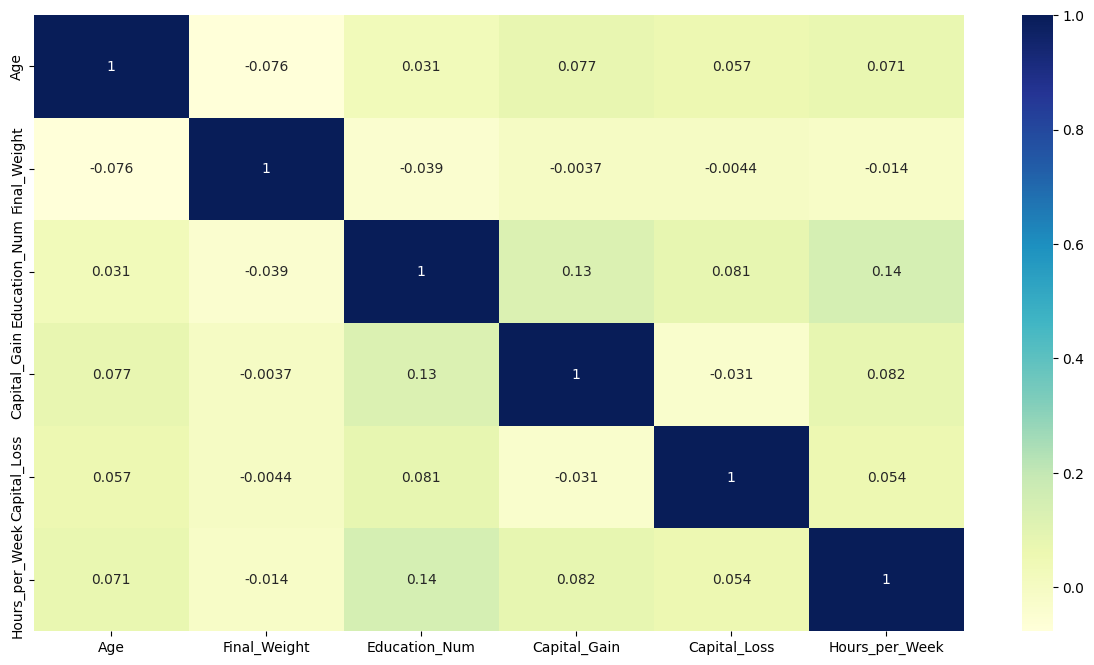

In [176]:
numeric_data = census_income_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="YlGnBu")

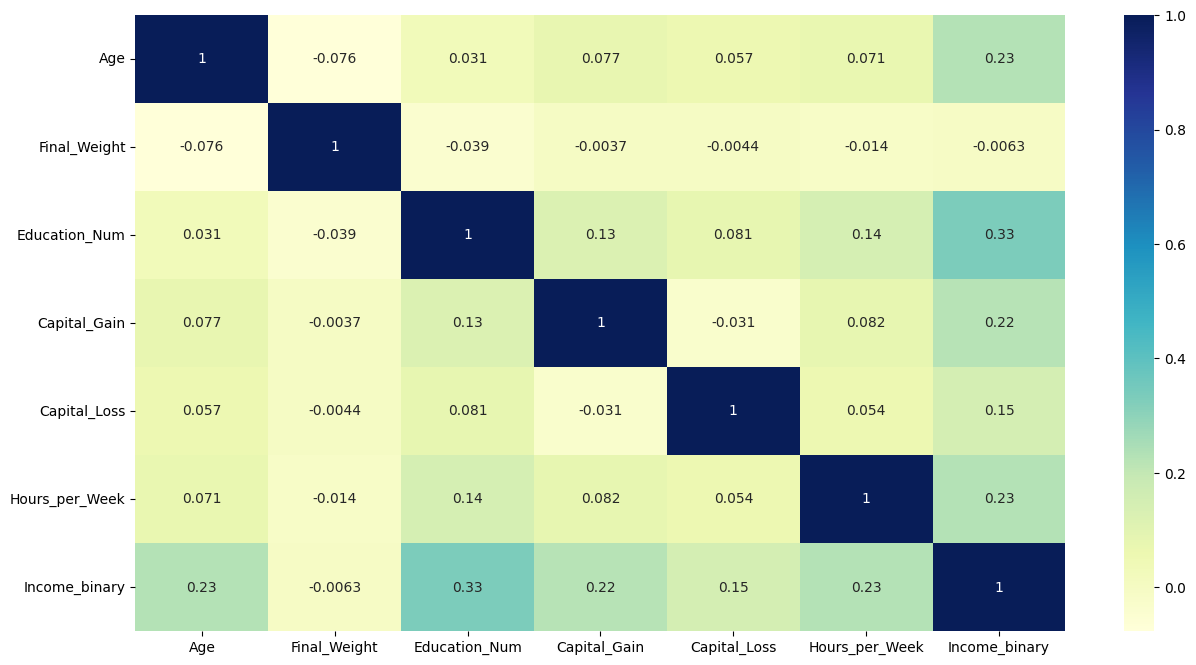

In [177]:
# Convert 'Income' column to binary values
census_income_df['Income_binary'] = np.where(census_income_df['Income'] == '>50K', 1, 0)

# Select numeric columns including the new 'Income_binary' column
numeric_data_with_income = census_income_df.select_dtypes(include=[np.number])

# Plot correlation heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(numeric_data_with_income.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [178]:
census_income_df.head(1)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income,Income_binary
0,80,private,227210,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,9386,0,40,united-states,>50K,1


In [179]:
# Drop the 'Income_binary' column
census_income_df.drop(columns=['Income_binary'], inplace=True)

In [180]:
census_income_df.head(1)

,Age,Work_class,Final_Weight,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,80,private,227210,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,9386,0,40,united-states,>50K


By considering the correlation heatmap we can see 'Final_Weight' and 'Income' column has -0.0063 correlation. So we can remove 'Final_Weight' from the dataframe

Remove Final_Weight column

In [181]:
# Remove the 'Final_Weight' column from the dataframe
census_income_df.drop(columns=['Final_Weight'], inplace=True)

In [182]:
census_income_df.head(1)

,Age,Work_class,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_Week,Native_Country,Income
0,80,private,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,9386,0,40,united-states,>50K


### 6.Handling Outliers

Outliers are data points that significantly differ from other observations in a dataset. They can arise due to various reasons such as measurement errors, data entry errors, or genuine variability in the data. 

Reference - https://www.linkedin.com/pulse/handling-outliers-ml-best-practices-robust-data-iain-brown-ph-d--mwf6e/, https://towardsdatascience.com/outlier-detection-methods-in-machine-learning-1c8b7cca6cb8

 0   Age             48789 non-null  int64 
 1   Work_class      48789 non-null  object
 2   Final_Weight    48789 non-null  int64 
 3   Education       48789 non-null  object
 4   Education_Num   48789 non-null  int64 
 5   Marital_Status  48789 non-null  object
 6   Occupation      48789 non-null  object
 7   Relationship    48789 non-null  object
 8   Race            48789 non-null  object
 9   Sex             48789 non-null  object
 10  Capital_Gain    48789 non-null  int64 
 11  Capital_Loss    48789 non-null  int64 
 12  Hours_per_Week  48789 non-null  int64 
 13  Native_Country  48789 non-null  object
 14  Income          48789 non-null  object

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Education_Num'}>],
       [<Axes: title={'center': 'Capital_Gain'}>,
        <Axes: title={'center': 'Capital_Loss'}>],
       [<Axes: title={'center': 'Hours_per_Week'}>, <Axes: >]],
      dtype=object)

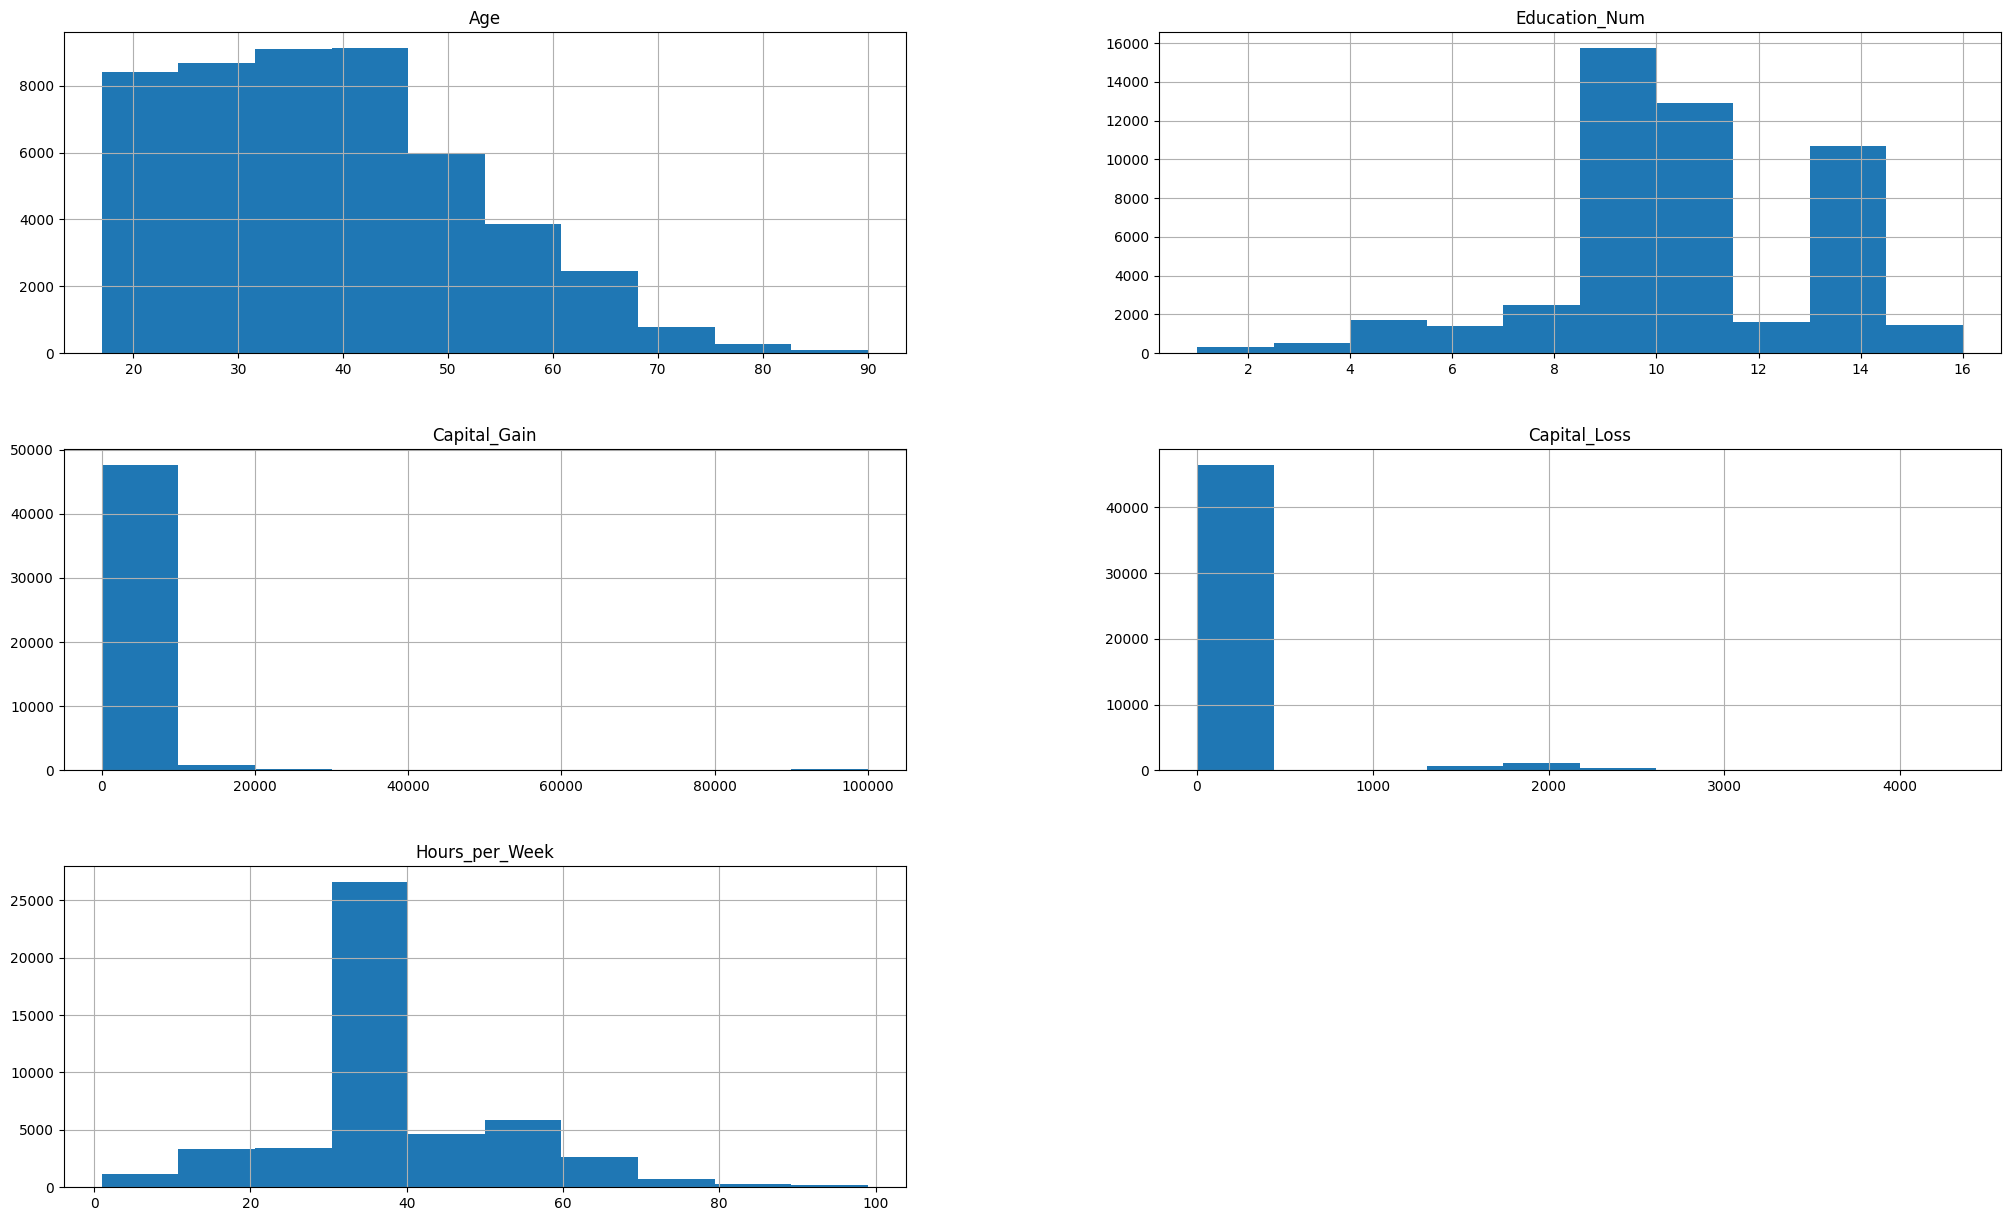

In [183]:
census_income_df.hist(figsize=(25, 15))

### Handle Age column outliers

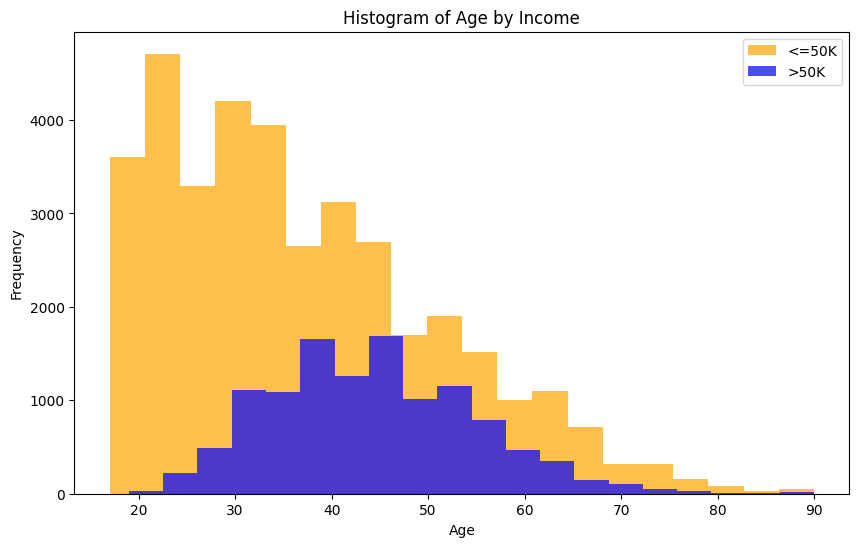

In [184]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Age column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Age'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Age'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Age by Income')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [185]:
census_income_df['Age'].describe()

count    48789.000000
mean        38.652647
std         13.708593
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: Age, dtype: float64

In the Age column, for both >50k income and <=50k has Right-skewed distribution. So IQR method might be a better choice

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


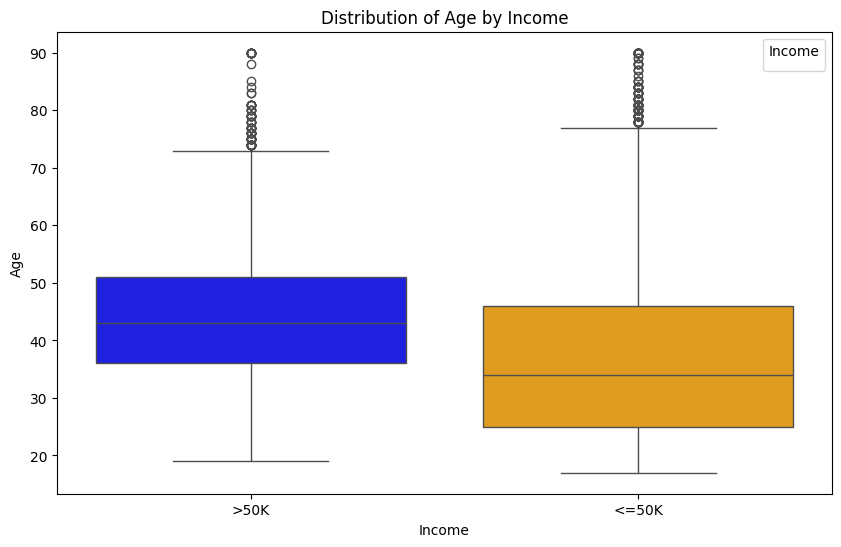

In [186]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Age" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Age"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Age by Income")
plt.ylabel("Age")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of age column which Income >50K

In [187]:
# Select age data for income >50k
age_over50K = census_income_df[census_income_df['Income'] == '>50K']['Age']

# calculate IQR
Q1 = age_over50K.quantile(0.25)
Q3 = age_over50K.quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower limit:", lower_bound)
print("Upper limit:", upper_bound)

Lower limit: 13.5
Upper limit: 73.5


In [188]:
# get count of rows where income is >50K and age is greater than upper bound
outliers_over50K_age = census_income_df[(census_income_df['Income'] == '>50K') & (census_income_df['Age'] > upper_bound)]

print("Number of rows with income >50K and age > upper bound:", len(outliers_over50K_age))

Number of rows with income >50K and age > upper bound: 90


Informations about that rows

In [189]:
outliers_over50K_age['Age'].describe()

count    90.000000
mean     79.022222
std       5.348480
min      74.000000
25%      75.000000
50%      77.000000
75%      81.000000
max      90.000000
Name: Age, dtype: float64

By analyzing data I considerd adjusting the outliers instead of removing them.So set any age value above the upper bound to the whole number of the upper bound value (73) 

In [190]:
# Cap outliers at the upper bound value (rounded down to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Age'] > upper_bound), 'Age'] = int(upper_bound)

In [191]:
print("Age column unique values")
print(census_income_df['Age'].unique())

Age column unique values
[73 53 29 66 33 46 27 34 25 18 47 21 31 32 44 19 28 35 55 90 56 52 23 20
 22 51 38 39 72 71 43 41 54 67 30 40 24 49 37 50 48 26 42 62 58 57 17 45
 36 74 65 60 59 68 69 61 79 63 76 75 83 70 64 80 78 77 84 82 81 87 89 85
 88 86]


After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


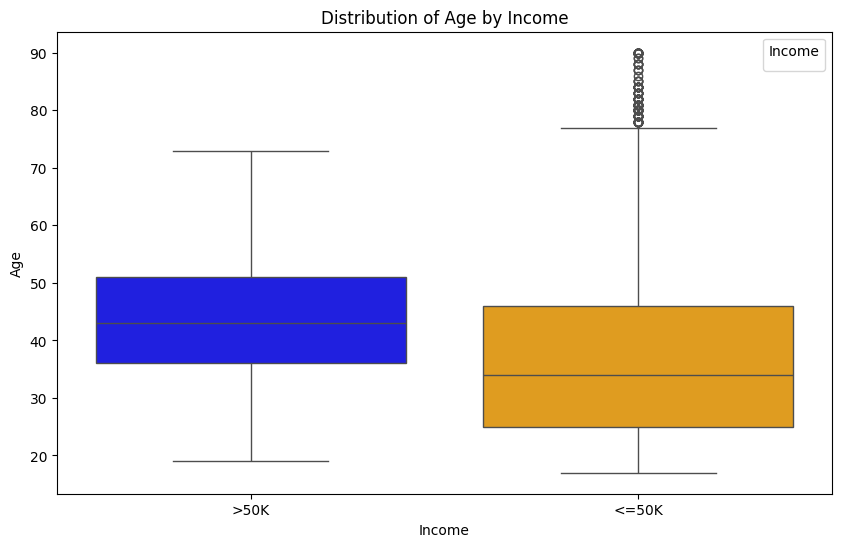

In [192]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Age" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Age"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Age by Income")
plt.ylabel("Age")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of age column which Income <=50K

In [193]:
# Select age data for income <= 50k
age_under50K = census_income_df[census_income_df['Income'] == '<=50K']['Age']

# Calculate IQR
Q1 = age_under50K.quantile(0.25)
Q3 = age_under50K.quantile(0.75)
IQR = Q3 - Q1

# upper bounds
upper_bound = Q3 + 1.5 * IQR

print("Upper limit:", upper_bound)

Upper limit: 77.5


In [194]:
# get count of rows where income is <=50K and age is greater than upper bound
outliers_under50K_age = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Age'] > upper_bound)]

print("Number of rows with income <=50K and age > upper bound:", len(outliers_under50K_age))

Number of rows with income <=50K and age > upper bound: 206


Informations about that rows

In [195]:
outliers_under50K_age['Age'].describe()

count    206.000000
mean      82.771845
std        4.295361
min       78.000000
25%       80.000000
50%       81.000000
75%       85.750000
max       90.000000
Name: Age, dtype: float64

By analyzing data, I considerd adjusting the outliers instead of removing them.So set any age value above the upper bound to the whole number of the upper bound value (77) 

In [196]:
# Cap outliers at the upper bound value for income <=50K and age > upper bound
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Age'] > upper_bound), 'Age'] = int(upper_bound)

In [197]:
print("Age column unique values")
print(census_income_df['Age'].unique())

Age column unique values
[73 53 29 66 33 46 27 34 25 18 47 21 31 32 44 19 28 35 55 77 56 52 23 20
 22 51 38 39 72 71 43 41 54 67 30 40 24 49 37 50 48 26 42 62 58 57 17 45
 36 74 65 60 59 68 69 61 63 76 75 70 64]


After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


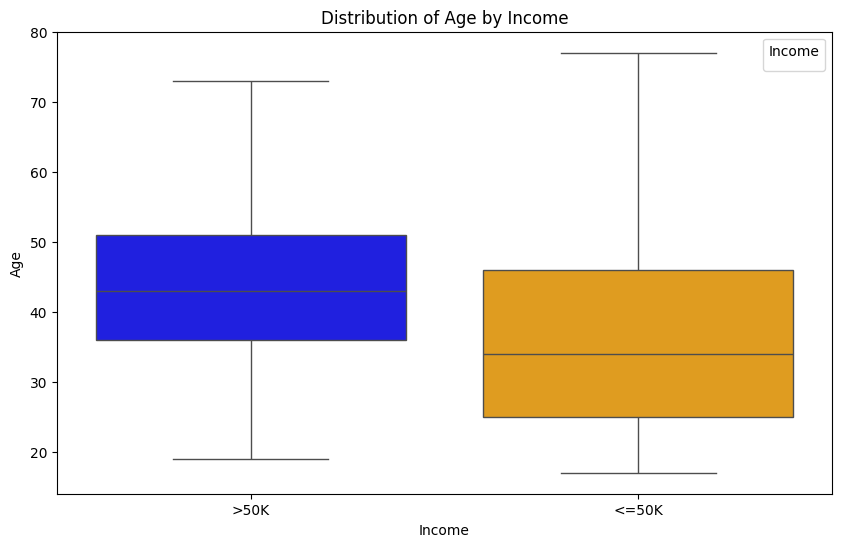

In [198]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Age" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Age"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Age by Income")
plt.ylabel("Age")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Education_Num column outliers

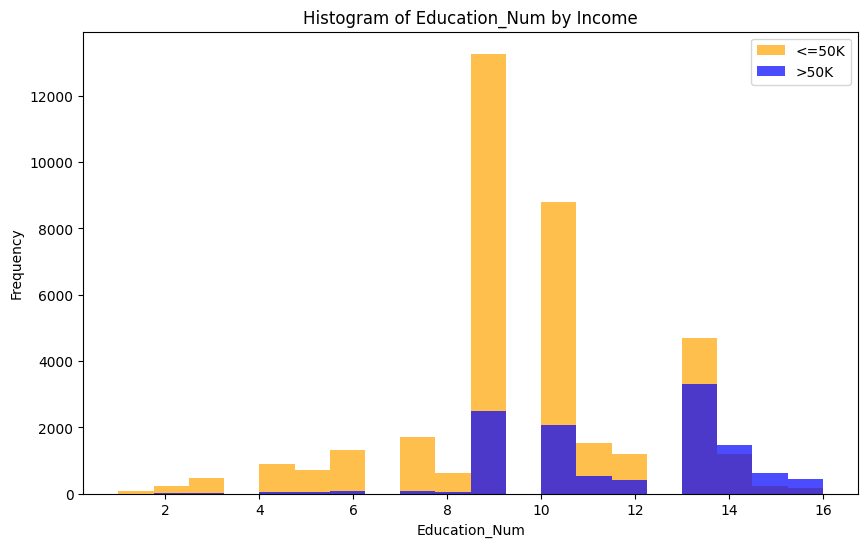

In [199]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Education_Num column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Education_Num'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Education_Num'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Education_Num by Income')
plt.xlabel('Education_Num')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In the Education_Num column, for both >50k income and <=50k has Left-skewed distribution. So IQR method might be a better choice

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


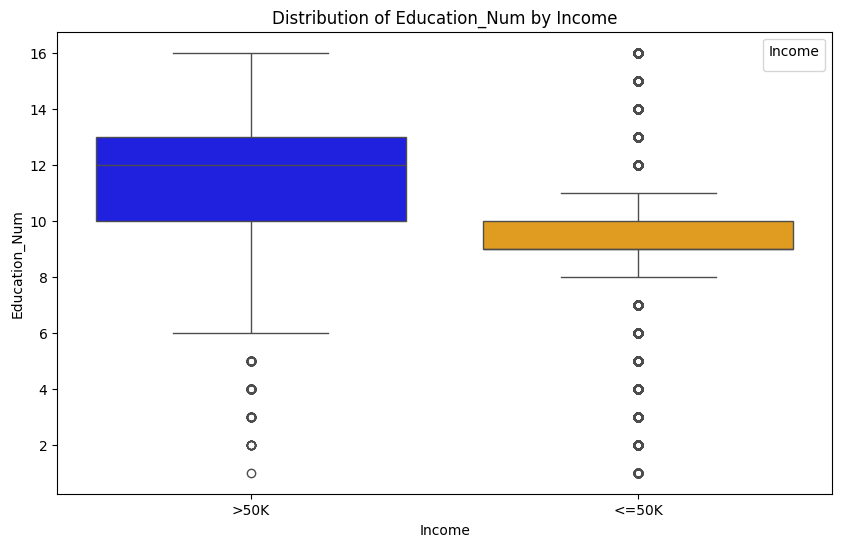

In [200]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Education_Num" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Education_Num"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Education_Num by Income")
plt.ylabel("Education_Num")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of Education_Num column which Income >50K

In [201]:
# Select Education_Num data for income >50k
education_num_over50K = census_income_df[census_income_df['Income'] == '>50K']['Education_Num']

# calculate IQR
Q1 = education_num_over50K.quantile(0.25)
Q3 = education_num_over50K.quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR

print("Lower limit:", lower_bound)

Lower limit: 5.5


In [202]:
# get count of rows where income is >50K and Education_Num is less than the lower bound
outliers_over50K_education_num = census_income_df[(census_income_df['Income'] == '>50K') & (census_income_df['Education_Num'] < lower_bound)]

print("Number of rows with income >50K and Education_Num < lower bound:", len(outliers_over50K_education_num))

Number of rows with income >50K and Education_Num < lower bound: 139


When handeling outliers of income >50K and Education_Num < lower bound we want to round the lower bound value up to the nearest whole number 

In [203]:
# Cap outliers at the lower bound value (rounded up to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '>50K') & (census_income_df['Education_Num'] < lower_bound), 'Education_Num'] = math.ceil(lower_bound)

After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


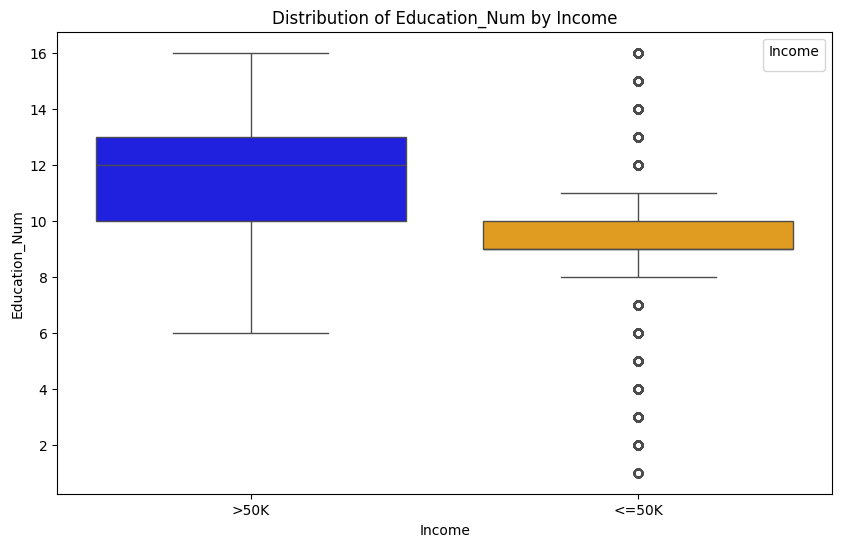

In [204]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Education_Num" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Education_Num"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Education_Num by Income")
plt.ylabel("Education_Num")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

Remove outliers of Education_Num column which Income <=50K

In [205]:
# Select Education_Num data for income <=50k
education_num_under50K = census_income_df[census_income_df['Income'] == '<=50K']['Education_Num']

# calculate IQR
Q1 = education_num_under50K.quantile(0.25)
Q3 = education_num_under50K.quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

Lower bound: 7.5
Upper bound: 11.5


In [206]:
# get count of rows where income is <=50K and Education_Num is less than the lower bound
outliers_under50K_education_num_lower = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] < lower_bound)]

# get count of rows where income is <=50K and Education_Num is greater than the upper bound
outliers_under50K_education_num_upper = census_income_df[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] > upper_bound)]

print("Number of rows with income <=50K and Education_Num < lower bound:", len(outliers_under50K_education_num_lower))
print("Number of rows with income <=50K and Education_Num > upper bound:", len(outliers_under50K_education_num_upper))

Number of rows with income <=50K and Education_Num < lower bound: 5426
Number of rows with income <=50K and Education_Num > upper bound: 7467


In [207]:
# Cap outliers at the lower bound value (rounded up to the nearest whole number)
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] < lower_bound), 'Education_Num'] = math.ceil(lower_bound)

# Cap outliers at the upper bound value for income <=50K and Education_Num > upper bound
census_income_df.loc[(census_income_df['Income'] == '<=50K') & (census_income_df['Education_Num'] > upper_bound), 'Education_Num'] = int(upper_bound)

After handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


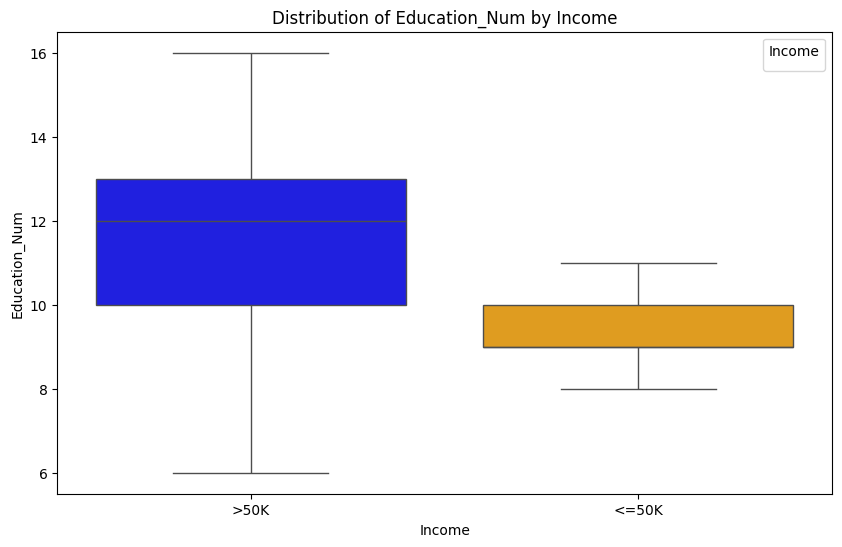

In [208]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Education_Num" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Education_Num"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Education_Num by Income")
plt.ylabel("Education_Num")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Capital_Gain column outliers

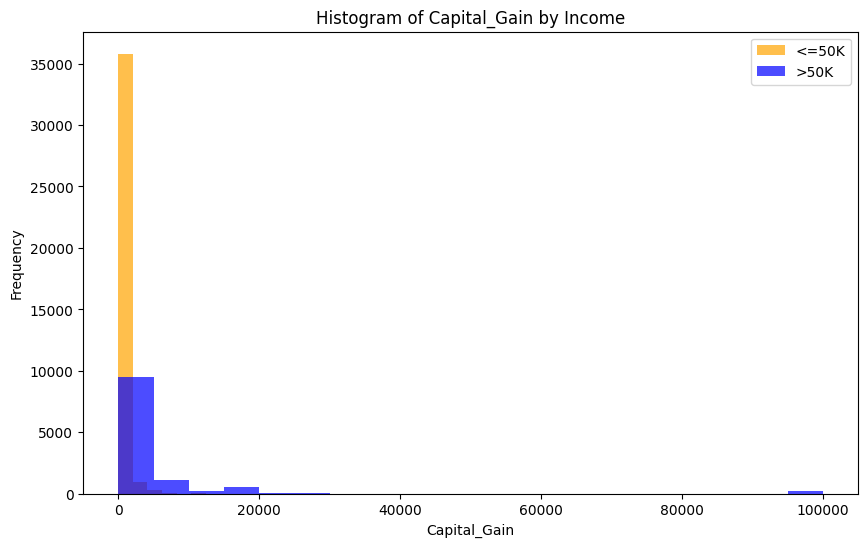

In [210]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Capital_Gain column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Capital_Gain'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Capital_Gain'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Capital_Gain by Income')
plt.xlabel('Capital_Gain')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In the Capital_Gain column, for both >50k income and <=50k has Right-skewed distribution. So IQR method might be a better choice

Before handeling outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


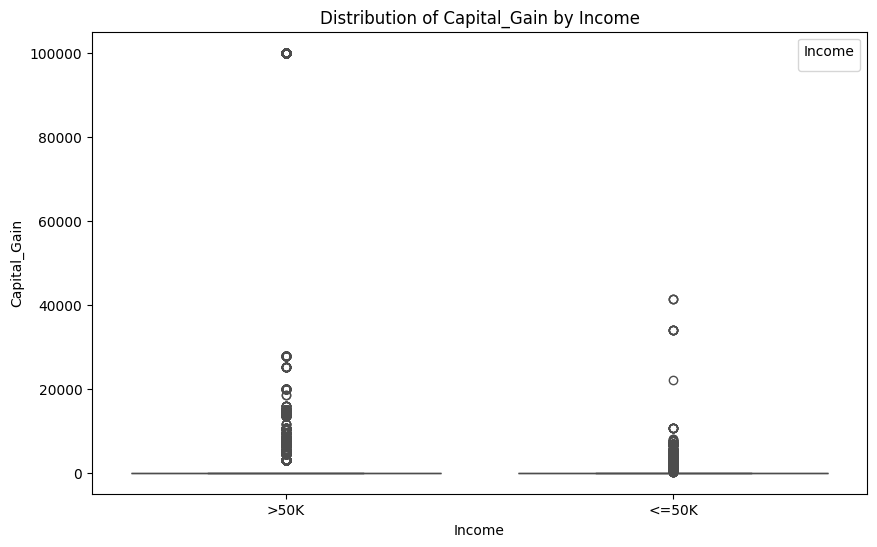

In [211]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create a box plot for the "Capital_Gain" column with hue for income group
plt.figure(figsize=(10, 6))
sns.boxplot(y=census_income_df["Capital_Gain"], x=census_income_df["Income"], hue=census_income_df["Income"], palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Capital_Gain by Income")
plt.ylabel("Capital_Gain")
plt.xlabel("Income")
plt.legend(title='Income', loc='upper right')
plt.show()

This boxplot doesn't provide meaningful insights due to the wide range of values and potential outliers

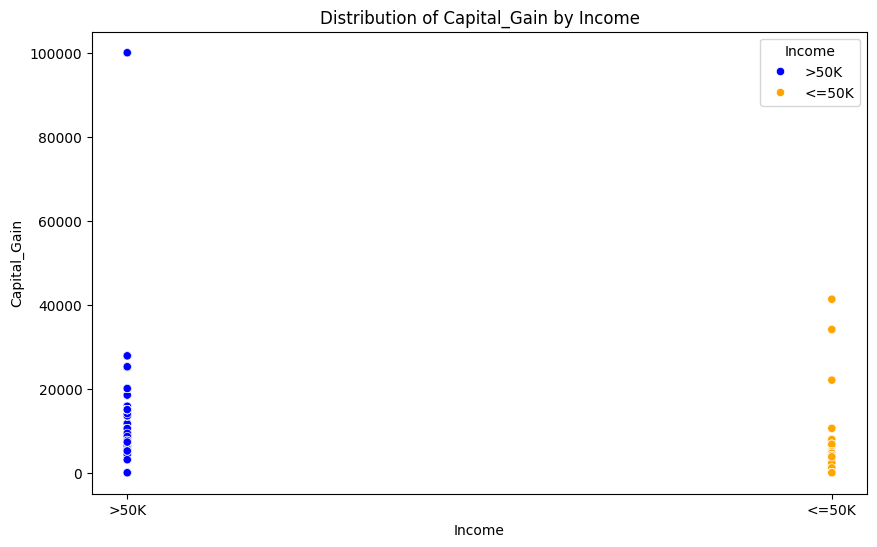

In [212]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Create scatter plots for the "Capital_Gain" column with hue for income group
plt.figure(figsize=(10, 6))
sns.scatterplot(data=census_income_df, x="Income", y="Capital_Gain", hue="Income", palette={'>50K': over50K_color, '<=50K': under50K_color})
plt.title("Distribution of Capital_Gain by Income")
plt.xlabel("Income")
plt.ylabel("Capital_Gain")
plt.legend(title='Income', loc='upper right')
plt.show()

### Handle Capital_Loss column outliers

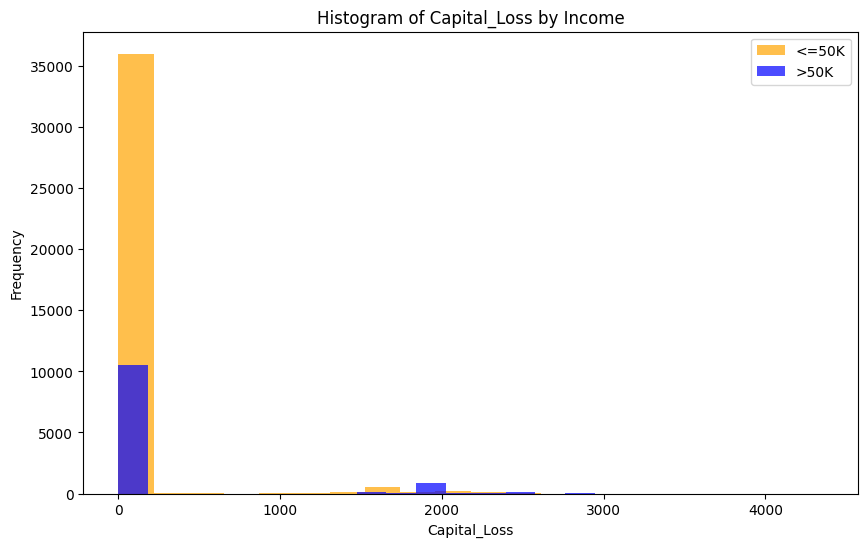

In [213]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Capital_Gain column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Capital_Loss'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Capital_Loss'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Capital_Loss by Income')
plt.xlabel('Capital_Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Handle Hours_per_Week column outliers

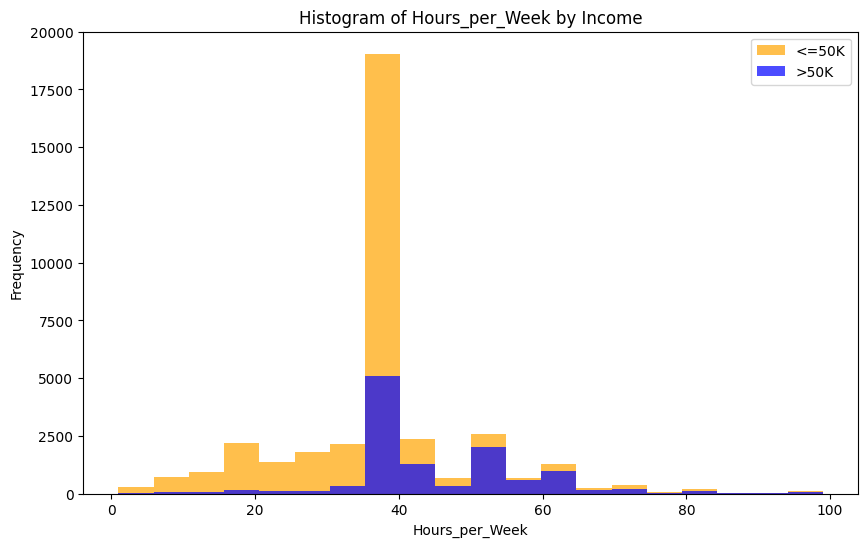

In [214]:
# Define colors for income groups
under50K_color = 'orange'
over50K_color = 'blue'

# Plot histogram for Capital_Gain column by income group
plt.figure(figsize=(10, 6))
plt.hist(census_income_df[census_income_df['Income'] == '<=50K']['Hours_per_Week'], bins=20, color=under50K_color, alpha=0.7, label='<=50K')
plt.hist(census_income_df[census_income_df['Income'] == '>50K']['Hours_per_Week'], bins=20, color=over50K_color, alpha=0.7, label='>50K')
plt.title('Histogram of Hours_per_Week by Income')
plt.xlabel('Hours_per_Week')
plt.ylabel('Frequency')
plt.legend()
plt.show()